# Fraud Detection — Threshold Strategy

This notebook moves from probability predictions to business decisions.

Instead of using the default 0.5 threshold, we determine a threshold
based on fraud detection priorities.

Goal:
- Achieve high recall (catch fraud)
- Accept controlled false positives
- Store threshold as part of model metadata

# Libraries

In [24]:
import pandas as pd 
import joblib 
import json
import numpy as np          
import matplotlib.pyplot as plt          

from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_recall_curve,
                             classification_report,
                             confusion_matrix)

RANDOM_STATE= 42

# Load Model & Data

In [2]:
# Load Saved Model
model = joblib.load("../models/baseline_pipeline.pkl")

# Load Processed Data
df = pd.read_csv("../data/processed/creditcard_processed.csv")

X = df.drop("Class", axis=1)
y = df["Class"]

# Same split used during training
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

# Generate Probabilities

In [3]:
y_proba = model.predict_proba(X_test)[:, 1]

# Precision-Recall Curve


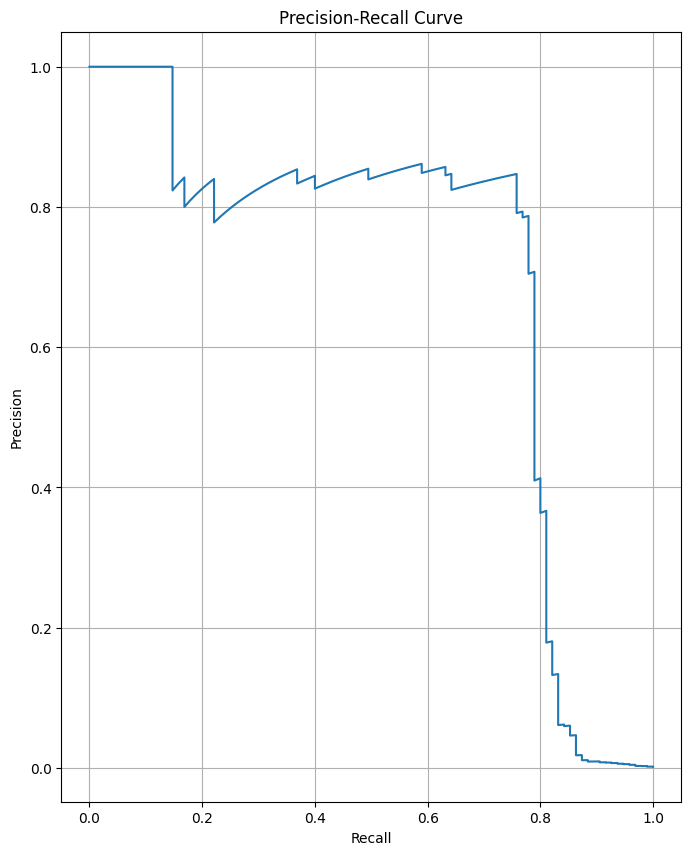

In [4]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 10))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

- The curve shows strong model performance. Precision remains high across a wide range of recall values, indicating the model can identify a substantial portion of fraud cases while keeping false positives relatively low. The expected precision drop at very high recall reflects the tradeoff between capturing more fraud and increasing false alerts.


# Threshold Selection Strategy

Business Assumption:
- Missing fraud is costly.
- We target at least 70% recall.

We now compute the smallest threshold achieving this recall.


In [22]:
# Select Threshold
target_recall = 0.70

idx = np.where(recall[:-1] >= target_recall)[0][-1]
chosen_threshold = thresholds[idx]

chosen_threshold

np.float64(0.19005692381898134)

In [23]:
# Apply Custom Threshold
y_pred_custom = (y_proba >= chosen_threshold).astype(int)

print(classification_report(y_test, y_pred_custom))
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred_custom)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.84      0.71      0.77        95

    accuracy                           1.00     56746
   macro avg       0.92      0.85      0.88     56746
weighted avg       1.00      1.00      1.00     56746

Confusion Matrix:
 [[56638    13]
 [   28    67]]


- Using a threshold selected to achieve ~70% recall resulted in a strong performance balance. The model detects 71% of fraud cases while maintaining very low false positives (13 out of 56k legitimate transactions). Fraud precision of 0.84 indicates that most flagged transactions are truly fraudulent, making this a practical operating point for deployment.


In [27]:
# Save Threshold Metadata
metadata = {
    "model_type": "LogisticRegression",
    "threshold": float(chosen_threshold),
    "target_recall": 0.70,
    "decision_policy": "Recall-prioritized fraud detection"
}

with open("../models/metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

metadata

{'model_type': 'LogisticRegression',
 'threshold': 0.19005692381898134,
 'target_recall': 0.7,
 'decision_policy': 'Recall-prioritized fraud detection'}

In [28]:
# Save Threshold Metadata
threshold_metrics = {
    "threshold": float(chosen_threshold),
    "recall_target": 0.70
}

with open("../reports/metrics/threshold_analysis.json", "w") as f:
    json.dump(threshold_metrics, f, indent=4)